In [1]:
from __future__ import print_function, division

import torch
import math
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.autograd import Variable
import random
import torch.nn.functional as F

exp_num = "test"


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
#     tf.set_random_seed(seed)

seed = 2019
seed_everything(seed)

In [3]:
#https://github.com/4uiiurz1/pytorch-auto-augment

import random
import numpy as np
import scipy
from scipy import ndimage
from PIL import Image, ImageEnhance, ImageOps


class AutoAugment(object):
    def __init__(self):
        self.policies = [
            ['Invert', 0.1, 7, 'Contrast', 0.2, 6],
            ['Rotate', 0.7, 2, 'TranslateX', 0.3, 9],
            ['Sharpness', 0.8, 1, 'Sharpness', 0.9, 3],
            ['ShearY', 0.5, 8, 'TranslateY', 0.7, 9],
            ['AutoContrast', 0.5, 8, 'Equalize', 0.9, 2],
            ['ShearY', 0.2, 7, 'Posterize', 0.3, 7],
            ['Color', 0.4, 3, 'Brightness', 0.6, 7],
            ['Sharpness', 0.3, 9, 'Brightness', 0.7, 9],
            ['Equalize', 0.6, 5, 'Equalize', 0.5, 1],
            ['Contrast', 0.6, 7, 'Sharpness', 0.6, 5],
            ['Color', 0.7, 7, 'TranslateX', 0.5, 8],
            ['Equalize', 0.3, 7, 'AutoContrast', 0.4, 8],
            ['TranslateY', 0.4, 3, 'Sharpness', 0.2, 6],
            ['Brightness', 0.9, 6, 'Color', 0.2, 8],
            ['Solarize', 0.5, 2, 'Invert', 0.0, 3],
            ['Equalize', 0.2, 0, 'AutoContrast', 0.6, 0],
            ['Equalize', 0.2, 8, 'Equalize', 0.6, 4],
            ['Color', 0.9, 9, 'Equalize', 0.6, 6],
            ['AutoContrast', 0.8, 4, 'Solarize', 0.2, 8],
            ['Brightness', 0.1, 3, 'Color', 0.7, 0],
            ['Solarize', 0.4, 5, 'AutoContrast', 0.9, 3],
            ['TranslateY', 0.9, 9, 'TranslateY', 0.7, 9],
            ['AutoContrast', 0.9, 2, 'Solarize', 0.8, 3],
            ['Equalize', 0.8, 8, 'Invert', 0.1, 3],
            ['TranslateY', 0.7, 9, 'AutoContrast', 0.9, 1],
        ]

    def __call__(self, img):
        img = apply_policy(img, self.policies[random.randrange(len(self.policies))])
        return img


operations = {
    'ShearX': lambda img, magnitude: shear_x(img, magnitude),
    'ShearY': lambda img, magnitude: shear_y(img, magnitude),
    'TranslateX': lambda img, magnitude: translate_x(img, magnitude),
    'TranslateY': lambda img, magnitude: translate_y(img, magnitude),
    'Rotate': lambda img, magnitude: rotate(img, magnitude),
    'AutoContrast': lambda img, magnitude: auto_contrast(img, magnitude),
    'Invert': lambda img, magnitude: invert(img, magnitude),
    'Equalize': lambda img, magnitude: equalize(img, magnitude),
    'Solarize': lambda img, magnitude: solarize(img, magnitude),
    'Posterize': lambda img, magnitude: posterize(img, magnitude),
    'Contrast': lambda img, magnitude: contrast(img, magnitude),
    'Color': lambda img, magnitude: color(img, magnitude),
    'Brightness': lambda img, magnitude: brightness(img, magnitude),
    'Sharpness': lambda img, magnitude: sharpness(img, magnitude),
    'Cutout': lambda img, magnitude: cutout(img, magnitude),
}


def apply_policy(img, policy):
    if random.random() < policy[1]:
        img = operations[policy[0]](img, policy[2])
    if random.random() < policy[4]:
        img = operations[policy[3]](img, policy[5])

    return img


def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = offset_matrix @ matrix @ reset_matrix
    return transform_matrix


def shear_x(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-0.3, 0.3, 11)

    transform_matrix = np.array([[1, random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]), 0],
                                 [0, 1, 0],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img


def shear_y(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-0.3, 0.3, 11)

    transform_matrix = np.array([[1, 0, 0],
                                 [random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]), 1, 0],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img


def translate_x(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-150/331, 150/331, 11)

    transform_matrix = np.array([[1, 0, 0],
                                 [0, 1, img.shape[1]*random.uniform(magnitudes[magnitude], magnitudes[magnitude+1])],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img


def translate_y(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-150/331, 150/331, 11)

    transform_matrix = np.array([[1, 0, img.shape[0]*random.uniform(magnitudes[magnitude], magnitudes[magnitude+1])],
                                 [0, 1, 0],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img


def rotate(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-30, 30, 11)
    theta = np.deg2rad(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    transform_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                 [np.sin(theta), np.cos(theta), 0],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img


def auto_contrast(img, magnitude):
    img = ImageOps.autocontrast(img)
    return img


def invert(img, magnitude):
    img = ImageOps.invert(img)
    return img


def equalize(img, magnitude):
    img = ImageOps.equalize(img)
    return img


def solarize(img, magnitude):
    magnitudes = np.linspace(0, 256, 11)
    img = ImageOps.solarize(img, random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img


def posterize(img, magnitude):
    magnitudes = np.linspace(4, 8, 11)
    img = ImageOps.posterize(img, int(round(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))))
    return img


def contrast(img, magnitude):
    magnitudes = np.linspace(0.1, 1.9, 11)
    img = ImageEnhance.Contrast(img).enhance(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img


def color(img, magnitude):
    magnitudes = np.linspace(0.1, 1.9, 11)
    img = ImageEnhance.Color(img).enhance(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img


def brightness(img, magnitude):
    magnitudes = np.linspace(0.1, 1.9, 11)
    img = ImageEnhance.Brightness(img).enhance(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img


def sharpness(img, magnitude):
    magnitudes = np.linspace(0.1, 1.9, 11)
    img = ImageEnhance.Sharpness(img).enhance(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img


def cutout(org_img, magnitude=None):
    img = np.array(img)

    magnitudes = np.linspace(0, 60/331, 11)

    img = np.copy(org_img)
    mask_val = img.mean()

    if magnitude is None:
        mask_size = 16
    else:
        mask_size = int(round(img.shape[0]*random.uniform(magnitudes[magnitude], magnitudes[magnitude+1])))
    top = np.random.randint(0 - mask_size//2, img.shape[0] - mask_size)
    left = np.random.randint(0 - mask_size//2, img.shape[1] - mask_size)
    bottom = top + mask_size
    right = left + mask_size

    if top < 0:
        top = 0
    if left < 0:
        left = 0

    img[top:bottom, left:right, :].fill(mask_val)

    img = Image.fromarray(img)

    return img



class Cutout(object):
    def __init__(self, length=16):
        self.length = length

    def __call__(self, img):
        img = np.array(img)

        mask_val = img.mean()

        top = np.random.randint(0 - self.length//2, img.shape[0] - self.length)
        left = np.random.randint(0 - self.length//2, img.shape[1] - self.length)
        bottom = top + self.length
        right = left + self.length

        top = 0 if top < 0 else top
        left = 0 if left < 0 else top

        img[top:bottom, left:right, :] = mask_val

        img = Image.fromarray(img)

        return img

### MIXUP

In [4]:
alpha_ = 0.4


# def mixup_data(x, y, alpha=alpha_, use_cuda=True):
#     if alpha > 0:
#         lam = np.random.beta(alpha, alpha)
#     else:
#         lam = 1

#     batch_size = x.size()[0]
#     if use_cuda:
#         index = torch.randperm(batch_size).cuda()
#     else:
#         index = torch.randperm(batch_size)

#     mixed_x = lam * x + (1 - lam) * x[index, :]
#     y_a, y_b = y, y[index]
#     return mixed_x, y_a, y_b, lam

# def mixup_criterion(criterion, pred, y_a, y_b, lam):
#     return lam * criterion(pred.float().cuda(), y_a.float().cuda()) + (1 - lam) * criterion(pred.float().cuda(), y_b.float().cuda())


def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
#     print(y)
    y_a, y_b = y, y[index]
    
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [5]:
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)

In [6]:


plt.ion()   # interactive mode

EO_data_transforms = {
    'Training': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((30,30)),
        AutoAugment(),
        Cutout(),
#         transforms.RandomRotation(15,),
#         transforms.RandomResizedCrop(30),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.2913437], [0.12694514])
        
        
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        #transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'Test': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(30),
        transforms.ToTensor(),
        transforms.Normalize([0.2913437], [0.12694514])
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
       # transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'valid_EO': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((30,30)),
#         AutoAugment(),
        
#         transforms.RandomRotation(15,),
#         transforms.RandomResizedCrop(48),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.2913437], [0.12694514])
        
#         transforms.Grayscale(num_output_channels=1),
#         transforms.Resize(48),
#         transforms.ToTensor(),
#         transforms.Normalize([0.5], [0.5])
#         transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
       # transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}



# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'Training': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((52,52)),
        transforms.RandomRotation(15,),
        transforms.RandomResizedCrop(48),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.4062625], [0.12694514])
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        #transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'Test': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(48),
        transforms.ToTensor(),
        transforms.Normalize([0.4062625], [0.12694514])
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
       # transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'valid': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((52,52)),
        transforms.RandomRotation(15,),
        transforms.RandomResizedCrop(48),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.4062625], [0.12694514])
        
#         transforms.Grayscale(num_output_channels=1),
#         transforms.Resize(48),
#         transforms.ToTensor(),
#         transforms.Normalize([0.5], [0.5])
#         transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
       # transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}


# data_dir = '/mnt/sda1/cvpr21/Classification/ram'
# EO_image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           EO_data_transforms[x])
#                   for x in ['Training', 'Test']}
# EO_dataloaders = {x: torch.utils.data.DataLoader(EO_image_datasets[x], batch_size=256,
#                                              shuffle=True, num_workers=64, pin_memory=True)
#               for x in ['Training', 'Test']}
# EO_dataset_sizes = {x: len(EO_image_datasets[x]) for x in ['Training', 'Test']}
# EO_class_names = EO_image_datasets['Training'].classes



# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['Training', 'Test']}

# combine_dataset = ConcatDataset(EO_image_datasets, image_datasets)
# dataloaders = {x: torch.utils.data.DataLoader(combine_dataset[x], batch_size=256,
#                                              shuffle=True, num_workers=64, pin_memory=True)
#               for x in ['Training', 'Test']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Test']}
# class_names = image_datasets['Training'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# def imshow(inp, title=None):
#     """Imshow for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
# #     mean = np.array([0.1786, 0.4739, 0.5329])
# #     std = np.array([[0.0632, 0.1361, 0.0606]])
# #     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  # pause a bit so that plots are updated


    
# # Get a batch of training data
# EO_inputs, EO_classes = next(iter(EO_dataloaders['Training']))


# inputs, classes, k ,_= next(iter(dataloaders))






# # Make a grid from batch
# EO_out = torchvision.utils.make_grid(EO_inputs)

# out = torchvision.utils.make_grid(inputs)
# imshow(EO_out, title=[EO_class_names[x] for x in classes])

# imshow(out, title=[class_names[x] for x in classes])

In [7]:
from torch.utils import data
from tqdm import tqdm
from PIL import Image
output_dim = 10

class SAR_EO_Combine_Dataset(data.Dataset):
    def __init__(self,df_sar,dirpath_sar,transform_sar,df_eo=None,dirpath_eo=None,transform_eo=None,test = False):
        self.df_sar = df_sar
        self.test = test
        self.dirpath_sar = dirpath_sar
        self.transform_sar = transform_sar
        
        self.df_eo = df_eo
#         self.test = test
        self.dirpath_eo = dirpath_eo
        self.transform_eo = transform_eo
        #image data 
#         if not self.test:
#             self.image_arr = np.asarray(str(self.dirpath)+'/'+self.df.iloc[:, 0]+'.png')
#         else:
#             self.image_arr = np.asarray(str(self.dirpath)+'/'+self.df.iloc[:, 0])
        
#         #labels data
#         if not self.test:
#              self.label_df = self.df.iloc[:,1]
        
        # Calculate length of df
        self.data_len = len(self.df_sar.index)

    def __len__(self):
        return self.data_len
    
    
    def __getitem__(self, idx):
        image_name_sar = self.df_sar.img_name[idx]
        image_name_sar = os.path.join(self.dirpath_sar, image_name_sar)
        img_sar = Image.open(image_name_sar)#.convert('RGB')
        img_tensor_sar = self.transform_sar(img_sar)
        
        image_name_eo = self.df_eo.img_name[idx]
        image_name_eo = os.path.join(self.dirpath_eo, image_name_eo)
        img_eo = Image.open(image_name_eo)#.convert('RGB')
        img_tensor_eo = self.transform_eo(img_eo)
        
#         image_name = self.df.img_name[idx]
#         img = Image.open(image_name)#.convert('RGB')
#         img_tensor = self.transform(img)
        
        
        if not self.test:
            image_labels = int(self.df_sar.class_id[idx])
#             label_tensor = torch.zeros((1, output_dim))
#             for label in image_labels.split():
#                 label_tensor[0, int(label)] = 1
            image_label = torch.tensor(image_labels,dtype= torch.long)
            image_label = image_label.squeeze()
            
            image_labels_eo = int(self.df_eo.class_id[idx])
#             label_tensor_eo = torch.zeros((1, output_dim))
#             for label_eo in image_labels_eo.split():
#                 label_tensor_eo[0, int(label_eo)] = 1
            image_label_eo = torch.tensor(image_labels_eo,dtype= torch.long)
            image_label_eo = image_label_eo.squeeze()
#             print(image_label_eo)
            
            
            
            
            return (img_tensor_sar,image_label), (img_tensor_eo, image_label_eo)
        
        return (img_tensor_sar)


In [8]:
class SAR_EO_Combine_Dataset2(data.Dataset):
    def __init__(self,df_sar,dirpath_sar,transform_sar,df_eo=None,dirpath_eo=None,transform_eo=None,test = False):
        self.df_sar = df_sar
        self.test = test
        self.dirpath_sar = dirpath_sar
        self.transform_sar = transform_sar
        
        self.df_eo = df_eo
#         self.test = test
        self.dirpath_eo = dirpath_eo
        self.transform_eo = transform_eo
        #image data 
#         if not self.test:
#             self.image_arr = np.asarray(str(self.dirpath)+'/'+self.df.iloc[:, 0]+'.png')
#         else:
#             self.image_arr = np.asarray(str(self.dirpath)+'/'+self.df.iloc[:, 0])
        
#         #labels data
#         if not self.test:
#              self.label_df = self.df.iloc[:,1]
        
        # Calculate length of df
        self.data_len = len(self.df_sar.index)

    def __len__(self):
        return self.data_len
    
    
    def __getitem__(self, idx):
        image_name_sar = self.df_sar.img_name[idx]
        image_name_sar = os.path.join(self.dirpath_sar, image_name_sar)
        img_sar = Image.open(image_name_sar)#.convert('RGB')
        img_tensor_sar = self.transform_sar(img_sar)
        
        image_name_eo = self.df_eo.img_name[idx]
        image_name_eo = os.path.join(self.dirpath_eo, image_name_eo)
        img_eo = Image.open(image_name_eo)#.convert('RGB')
        img_tensor_eo = self.transform_eo(img_eo)
        
#         image_name = self.df.img_name[idx]
#         img = Image.open(image_name)#.convert('RGB')
#         img_tensor = self.transform(img)
        
        
        if not self.test:
            image_labels = int(self.df_sar.class_id[idx])
#             label_tensor = torch.zeros((1, output_dim))
#             for label in image_labels.split():
#                 label_tensor[0, int(label)] = 1
            image_label = torch.tensor(image_labels,dtype= torch.long)
            image_label = image_label.squeeze()
            
            image_labels_eo = int(self.df_eo.class_id[idx])
#             label_tensor_eo = torch.zeros((1, output_dim))
#             for label_eo in image_labels_eo.split():
#                 label_tensor_eo[0, int(label_eo)] = 1
            image_label_eo = torch.tensor(image_labels_eo,dtype= torch.long)
            image_label_eo = image_label_eo.squeeze()
#             print(image_label_eo)
            
            
            
            
            return (img_tensor_sar,image_label), (img_tensor_eo, image_label_eo)
        
        return (img_tensor_sar)

In [9]:
model = torch.load("../KD1/resnet34_kd114.pt")

import pandas as pd
from torch.utils import data
from tqdm import tqdm
from PIL import Image
class ImageData(data.Dataset):
    def __init__(self,df,dirpath,transform,test = False):
        self.df = df
        self.test = test
        self.dirpath = dirpath
        self.conv_to_tensor = transform
        #image data 
        if not self.test:
            self.image_arr = np.asarray(str(self.dirpath)+'/'+self.df.iloc[:, 0]+'.png')
        else:
            self.image_arr = np.asarray(str(self.dirpath)+'/'+self.df.iloc[:, 0])
        
        #labels data
        if not self.test:
             self.label_df = self.df.iloc[:,1]
        
        # Calculate length of df
        self.data_len = len(self.df.index)

    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        image_name = self.image_arr[idx]
        img = Image.open(image_name)#.convert('RGB')
        img_tensor = self.conv_to_tensor(img)
        if not self.test:
            image_labels = self.label_df[idx]
            label_tensor = torch.zeros((1, output_dim))
            for label in image_labels.split():
                label_tensor[0, int(label)] = 1
            image_label = torch.tensor(label_tensor,dtype= torch.float32)
            return (img_tensor,image_label.squeeze())
        return (img_tensor)

    
BATCH_SIZE = 1
test_dir = "./data/test" ## Change it to the test file path
test_dir_ls = os.listdir(test_dir)
test_dir_ls.sort()
test_df = pd.DataFrame(test_dir_ls)

test_dataset = ImageData(test_df,test_dir,EO_data_transforms["valid_EO"],test = True)
test_loader = data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False)

output_dim = 10

DISABLE_TQDM = False
predictions = np.zeros((len(test_dataset), output_dim))
i = 0
for test_batch in tqdm(test_loader,disable = DISABLE_TQDM):
    test_batch = test_batch.to(device)
    batch_prediction = model(test_batch).detach().cpu().numpy()
    predictions[i * BATCH_SIZE:(i+1) * BATCH_SIZE, :] = batch_prediction
    i+=1
    


100%|██████████| 826/826 [00:15<00:00, 53.29it/s]


### submission balance for class 0

0.2121564553048015


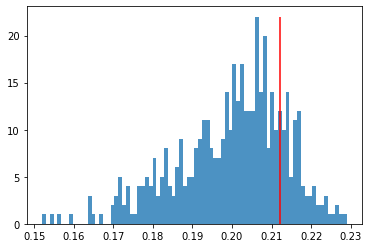

In [10]:
m = nn.Softmax(dim=1)
predictions_tensor = torch.from_numpy(predictions)
output_softmax = m(predictions_tensor)
# output_softmax = output_softmax/output_softmax.sum()

pred = np.argmax(predictions,axis = 1)

plot_ls = []
idx = 0
for each_pred in pred:
    if each_pred == 0:
        plot_ls.append(output_softmax[idx][0].item())
    idx+=1
# plot_ls
    

# idx = 0
# # print(output_softmax)
# for i in pred:
# #     print(predictions_tensor[idx])
#     each_output_softmax = output_softmax[idx]/output_softmax[idx].sum()
#     print(each_output_softmax)
#     if i == 0:
#         new_list = set(predictions[idx])
#         new_list.remove(max(new_list))
#         index = predictions[idx].tolist().index(max(new_list))
# #         index = predictions[idx].index()
# #         print(index)

        
#     idx+=1

import matplotlib.pyplot as plt
   
plt.hist(plot_ls, bins=80, histtype="stepfilled", alpha=.8)
plot_ls.sort()
val = plot_ls[-85]
print(val)
plt.vlines(val, ymin = 0, ymax = 22, colors = 'r')


    
        
            

In [11]:
# print(output_softmax)
idx = 0
counter = 0
for i in pred:
#     print(predictions_tensor[idx])
#     each_output_softmax = output_softmax[idx]/output_softmax[idx].sum()
#     print(each_output_softmax)
    if i == 0 and output_softmax[idx][0] < val:
        
        new_list = set(predictions[idx])
        new_list.remove(max(new_list))
        index = predictions[idx].tolist().index(max(new_list))
#         index = predictions[idx].index()
#         print(index)
        pred[idx] = index
        output_softmax[idx][0] = -100.0
        counter += 1
    

        
    idx+=1
print(counter)

374


### submission balance for class 1

0.21454049970403302


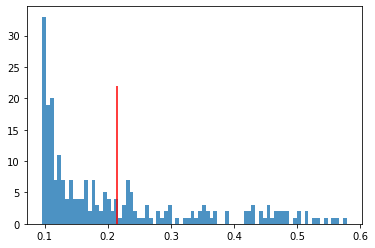

In [12]:




plot_ls = []
idx = 0
for each_pred in pred:
    if each_pred == 1:
        plot_ls.append(output_softmax[idx][1].item())
    idx+=1
# plot_ls
    

# idx = 0
# # print(output_softmax)
# for i in pred:
# #     print(predictions_tensor[idx])
#     each_output_softmax = output_softmax[idx]/output_softmax[idx].sum()
#     print(each_output_softmax)
#     if i == 0:
#         new_list = set(predictions[idx])
#         new_list.remove(max(new_list))
#         index = predictions[idx].tolist().index(max(new_list))
# #         index = predictions[idx].index()
# #         print(index)

        
#     idx+=1

import matplotlib.pyplot as plt
   
plt.hist(plot_ls, bins=80, histtype="stepfilled", alpha=.8)
plot_ls.sort()
val = plot_ls[-85]
print(val)
plt.vlines(val, ymin = 0, ymax = 22, colors = 'r')

In [13]:
# print(output_softmax)
idx = 0
counter = 0
for i in pred:
#     print(predictions_tensor[idx])
#     each_output_softmax = output_softmax[idx]/output_softmax[idx].sum()
#     print(each_output_softmax)
    if i == 1 and output_softmax[idx][1] < val:
        new_list = set(output_softmax[idx])
        new_list.remove(max(new_list))
        index = output_softmax[idx].tolist().index(max(new_list))
#         index = predictions[idx].index()
#         print(index)
        pred[idx] = index
        output_softmax[idx][1] = -100.0
        counter += 1
    

        
    idx+=1
print(counter)

154


### submission balance for class 2

0.11162966531637959


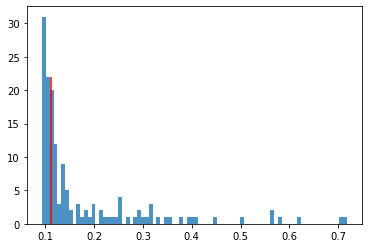

In [14]:


plot_ls = []
idx = 0
for each_pred in pred:
    if each_pred == 2:
        plot_ls.append(output_softmax[idx][2].item())
    idx+=1
# plot_ls
    

# idx = 0
# # print(output_softmax)
# for i in pred:
# #     print(predictions_tensor[idx])
#     each_output_softmax = output_softmax[idx]/output_softmax[idx].sum()
#     print(each_output_softmax)
#     if i == 0:
#         new_list = set(predictions[idx])
#         new_list.remove(max(new_list))
#         index = predictions[idx].tolist().index(max(new_list))
# #         index = predictions[idx].index()
# #         print(index)

        
#     idx+=1

import matplotlib.pyplot as plt
   
plt.hist(plot_ls, bins=80, histtype="stepfilled", alpha=.8)
plot_ls.sort()
val = plot_ls[-85]
print(val)
plt.vlines(val, ymin = 0, ymax = 22, colors = 'r')

In [15]:
#  print(output_softmax)
idx = 0
counter = 0
for i in pred:
#     print(predictions_tensor[idx])
#     each_output_softmax = output_softmax[idx]/output_softmax[idx].sum()
#     print(each_output_softmax)
    if i == 2 and output_softmax[idx][2] < val:
        new_list = set(output_softmax[idx])
        new_list.remove(max(new_list))
        index = output_softmax[idx].tolist().index(max(new_list))
#         index = predictions[idx].index()
#         print(index)
        pred[idx] = index
        output_softmax[idx][2] = -100.0
        counter += 1
    

        
    idx+=1
print(counter)

63


### submission balance for class 3

0.09716976256894183


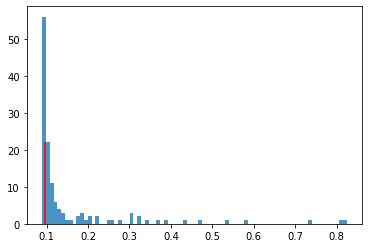

In [16]:

plot_ls = []
idx = 0
for each_pred in pred:
    if each_pred == 3:
        plot_ls.append(output_softmax[idx][3].item())
    idx+=1
# plot_ls
    

# idx = 0
# # print(output_softmax)
# for i in pred:
# #     print(predictions_tensor[idx])
#     each_output_softmax = output_softmax[idx]/output_softmax[idx].sum()
#     print(each_output_softmax)
#     if i == 0:
#         new_list = set(predictions[idx])
#         new_list.remove(max(new_list))
#         index = predictions[idx].tolist().index(max(new_list))
# #         index = predictions[idx].index()
# #         print(index)

        
#     idx+=1

import matplotlib.pyplot as plt
   
plt.hist(plot_ls, bins=80, histtype="stepfilled", alpha=.8)
plot_ls.sort()
val = plot_ls[-85]
print(val)
plt.vlines(val, ymin = 0, ymax = 22, colors = 'r')

In [17]:
#  print(output_softmax)
idx = 0
counter = 0
for i in pred:
#     print(predictions_tensor[idx])
#     each_output_softmax = output_softmax[idx]/output_softmax[idx].sum()
#     print(each_output_softmax)
    if i == 3 and output_softmax[idx][3] < val:
        new_list = set(output_softmax[idx])
        new_list.remove(max(new_list))
        index = output_softmax[idx].tolist().index(max(new_list))
#         index = predictions[idx].index()
#         print(index)
        pred[idx] = index
        output_softmax[idx][3] = -100.0
        counter += 1
    

        
    idx+=1
print(counter)

47


In [18]:
# pred = np.argmax(predictions,axis = 1)
pred_list = []
for i in range(len(pred)):
    result = [pred[i]]
    pred_list.append(result)
pred_list



[[2],
 [1],
 [0],
 [0],
 [5],
 [5],
 [4],
 [5],
 [1],
 [8],
 [1],
 [0],
 [0],
 [3],
 [5],
 [5],
 [0],
 [3],
 [4],
 [3],
 [8],
 [4],
 [3],
 [2],
 [0],
 [3],
 [3],
 [0],
 [4],
 [2],
 [5],
 [3],
 [1],
 [4],
 [5],
 [5],
 [6],
 [7],
 [5],
 [2],
 [7],
 [5],
 [3],
 [5],
 [0],
 [0],
 [0],
 [5],
 [0],
 [3],
 [2],
 [0],
 [5],
 [0],
 [4],
 [5],
 [7],
 [2],
 [5],
 [5],
 [1],
 [7],
 [2],
 [2],
 [1],
 [2],
 [1],
 [4],
 [0],
 [0],
 [7],
 [1],
 [6],
 [1],
 [2],
 [4],
 [4],
 [1],
 [0],
 [6],
 [4],
 [0],
 [1],
 [3],
 [5],
 [4],
 [4],
 [4],
 [0],
 [4],
 [5],
 [5],
 [5],
 [5],
 [6],
 [5],
 [6],
 [4],
 [5],
 [7],
 [0],
 [0],
 [0],
 [0],
 [2],
 [2],
 [5],
 [2],
 [1],
 [4],
 [2],
 [0],
 [3],
 [4],
 [4],
 [3],
 [2],
 [3],
 [5],
 [4],
 [5],
 [8],
 [4],
 [0],
 [4],
 [0],
 [1],
 [1],
 [5],
 [5],
 [4],
 [5],
 [0],
 [3],
 [0],
 [1],
 [0],
 [0],
 [4],
 [0],
 [1],
 [0],
 [3],
 [1],
 [0],
 [3],
 [2],
 [4],
 [4],
 [1],
 [6],
 [5],
 [5],
 [1],
 [0],
 [5],
 [5],
 [9],
 [0],
 [6],
 [4],
 [1],
 [3],
 [4],
 [3],
 [4],
 [4]

In [19]:
predicted_class_idx = pred_list

test_df['class_id'] = predicted_class_idx
test_df['class_id'] = test_df['class_id'].apply(lambda x : ' '.join(map(str,list(x))))
test_df = test_df.rename(columns={0: 'image_id'})
test_df['image_id'] = test_df['image_id'].apply(lambda x : x.split('.')[0])
test_df


,image_id,class_id
0,EO_100578,2
1,EO_10079,1
2,EO_102385,0
3,EO_10264,0
4,EO_103494,5
...,...,...
821,EO_93885,7
822,EO_95890,1
823,EO_96662,5
824,EO_97302,4


In [20]:
for (idx, row) in test_df.iterrows():
    row.image_id = row.image_id.split("_")[1]


In [21]:
for k in range(10):
    i = 0
    for (idx, row) in test_df.iterrows():
        if row.class_id == str(k):
            i+=1
    print(i)

113
103
95
85
132
135
21
119
18
5


In [22]:
test_df

,image_id,class_id
0,100578,2
1,10079,1
2,102385,0
3,10264,0
4,103494,5
...,...,...
821,93885,7
822,95890,1
823,96662,5
824,97302,4


In [23]:
test_df.to_csv('results.csv',index = False)